In [ ]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

!pip install transformers
from transformers import AutoModel, AutoTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.6 MB/s eta 0:00:00


In [ ]:
#Initialise GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
sns.set_theme()

logging.basicConfig(filename='training_log.log',
                    format='%(asctime)s - %(message)s', 
                    level=logging.INFO,
                    filemode='w')
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='training_log.log', mode='a')
formatter = logging.Formatter('%(asctime)s: %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Initialise Dataset and Model Classes

In [ ]:
class DS(Dataset):
    def __init__(self, data_path, sheet_name, model_ckpt, max_token_length=50):
        super().__init__()
        self.max_token_length = max_token_length

        # label encodings
        self.labels = [
            'hate',
            'privacy',
            'sexual',
            'impersonation',
            'illegal',
            'advertisement',
            'ai',
            'neutral'
        ]

        # load excel
        self.data = pd.read_csv(data_path)
        # self.data = pd.read_csv(data_path)
        # self.data = data.reset_index()

        self.tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.loc[idx, :]


        comment = row['body']
        comment = comment.split()

        # long comments
        if len(comment) > self.max_token_length: #token limit of BERT is 50.
            comment = comment[:45]
        comment = ' '.join(comment)
        comment = comment.replace("\\", "")

        emotion = row['label']
        emotion = self.labels.index(emotion)

        return f"{comment}", emotion

    def choose(self):
        return self[randint(0, len(self)-1)]

    def get_tokenizer_size(self):
        return len(self.tokenizer)

    def decode(self, input_id):
        return self.tokenizer.decode(input_id)

    def collate_fn(self, data):
        comments, emotions = zip(*data)
        comments = self.tokenizer(comments,
                                  padding=True,
                                  return_tensors='pt')
        comments = {k:v.to(device) for k, v in comments.items()}
        emotions = torch.tensor(emotions).long().to(device)
        return comments, emotions

In [ ]:
class SingleClassifier(nn.Module):
    def __init__(self, model_ckpt, nlabels, tokenizer_size=30523):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_ckpt)
        self.encoder.resize_token_embeddings(tokenizer_size)
        encoder_config = self.encoder.config
        self.classifier = nn.Sequential(
            nn.LayerNorm(encoder_config.hidden_size),
            nn.Dropout(0.3),
            nn.Linear(encoder_config.hidden_size, nlabels)
        )
    
    def get_summary(self):
        print(self)

    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        x = self.encoder(**x)
        x = x.last_hidden_state[:, 0] # [cls] emb
        x = self.classifier(x)
        return x

In [ ]:
def compute_metrics(targets, preds):
    targets = targets.cpu().detach()
    preds = preds.cpu().detach()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    return {'acc': acc, 'f1': f1, 'preds': preds, 'targets':targets}

In [ ]:
def ft_reg_loss(initial_model):
    init_param = []
    
    for layer in initial_model.parameters():
        init_param.append(layer.clone())
        
    def compute_loss(cur_model):
        loss_p = 0
        cur_param = cur_model.parameters()
        
        for l1, l2, in zip(init_param, cur_param):
            loss_p += torch.sum((l1 - l2)**2)
        
        return loss_p
    
    return compute_loss

In [ ]:
def focal_loss(gamma=2):
    def compute_loss(preds, targets):
        ce_loss = F.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-ce_loss) 
        return ((1-pt)**gamma * ce_loss).mean()
    return compute_loss

In [ ]:
def train(data, model, optimizer, label_loss_fn,
          ft_criterion, ft_lambda=1e-4):
    model.train()
    comments, labels = data
    label_outputs = model(comments)
    label_loss = label_loss_fn(label_outputs, labels)
    loss = label_loss
    model.zero_grad()
    loss.backward()
    optimizer.step()

    label_preds = label_outputs.argmax(-1)
    label_metrics = compute_metrics(labels, label_preds)
    return loss, label_metrics

In [ ]:
@torch.no_grad()
def validate(data, model, label_loss_fnn):
    model.eval()
    comments, labels = data
    label_outputs = model(comments)
    label_loss = label_loss_fnn(label_outputs, labels)
    loss = label_loss

    label_preds = label_outputs.argmax(-1)
    label_metrics = compute_metrics(labels, label_preds)
    return loss, label_metrics

# Import Data and Model Training

In [ ]:
data_path = "./data/processed.csv"
train_data_path = "./data/train.csv"
val_data_path = "./data/val.csv"
sheet_name = "Sheet1"
df = pd.read_csv(data_path)
df['label'] = df.iloc[:,1:].idxmax(1)
df = df[['body','label']]


train_df, val_df = train_test_split(df, stratify=df.loc[:, 'label'], test_size=0.1, random_state=123)
train_df.to_csv(train_data_path, index=False)
val_df.to_csv(val_data_path, index=False)
print(f'Size of training data: {len(train_df)}')
print(f'Size of validation data: {len(val_df)}')

Size of training data: 44188
Size of validation data: 4910


In [ ]:
model_ckpt = "GroNLP/hateBERT"
batch_size = 16

train_ds = DS(train_data_path, sheet_name, model_ckpt)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      drop_last=True, collate_fn=train_ds.collate_fn)
val_ds = DS(val_data_path, sheet_name, model_ckpt)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

In [ ]:
model = SingleClassifier(model_ckpt, nlabels=8).to(device)
model.unfreeze_encoder()
#model.get_summary()

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
n_epoch = 20
loss_fn = focal_loss() # nn.CrossEntropyLoss()
ft_criterion = ft_reg_loss(model.encoder)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [ ]:
mem = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

cur_best_f1 = 0

for epoch in tqdm(range(n_epoch), desc='Training'):

    n_batch = len(train_dl)
    train_losses = []
    train_accs = []
    train_f1s = []

    for i, data in enumerate(train_dl):
        train_loss, train_metrics = train(data, model, optimizer, loss_fn, loss_fn, ft_criterion)
        pos = epoch + ((i+1)/n_batch)
        train_losses.append(train_loss.cpu().detach())
        train_accs.append(train_metrics['acc'])
        train_f1s.append(train_metrics['f1'])
        log = f"epoch: {pos:.3f}\ttrain loss: {train_loss:.3f}\ttrain_acc: {train_metrics['acc']:.3f}\ttrain_f1: {train_metrics['f1']:.3f}"
        print('\r', log, end='')
    
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_acc'].append(np.mean(train_accs))
    mem['train_f1'].append(np.mean(train_f1s))

    n_batch = len(val_dl)
    val_losses = []
    val_accs = []
    val_f1s = []

    for i, data in enumerate(val_dl):
        val_loss, val_metrics = validate(data, model, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        val_losses.append(val_loss.cpu().detach())
        val_accs.append(val_metrics['acc'])
        val_f1s.append(val_metrics['f1'])
        log = f"epoch: {pos:.3f}\tval loss: {val_loss:.3f}\tval_acc: {val_metrics['acc']:.3f}\tval_f1: {val_metrics['f1']:.3f}"
        print('\r', log, end='')
    
    print('\r', end='')
    mem['val_loss'].append(np.mean(val_losses))
    mem['val_acc'].append(np.mean(val_accs))
    mem['val_f1'].append(np.mean(val_f1s))

    log = f"epoch: {epoch+1}\ntrain loss: {mem['train_loss'][-1]:.3f}\ttrain_acc: {mem['train_acc'][-1]:.3f}\ttrain_f1: {mem['train_f1'][-1]:.3f}"
    log = log + f"\nval loss:   {mem['val_loss'][-1]:.3f}\tval_acc:   {mem['val_acc'][-1]:.3f}\tval_f1:   {mem['val_f1'][-1]:.3f}\n"
    logger.info(log)
    print(log)
    scheduler.step()    

    if mem['val_f1'][-1] > cur_best_f1:
        torch.save(model.state_dict(), f"model_weights_bert1.pth")
        cur_best_f1 = mem['val_f1'][-1]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1
train loss: 0.014	train_acc: 0.980	train_f1: 0.980
val loss:   0.127	val_acc:   0.931	val_f1:   0.928

epoch: 2
train loss: 0.010	train_acc: 0.987	train_f1: 0.987
val loss:   0.141	val_acc:   0.935	val_f1:   0.932

epoch: 3
train loss: 0.007	train_acc: 0.992	train_f1: 0.991
val loss:   0.162	val_acc:   0.930	val_f1:   0.929

epoch: 4
train loss: 0.005	train_acc: 0.993	train_f1: 0.993
val loss:   0.173	val_acc:   0.928	val_f1:   0.926

epoch: 5
train loss: 0.004	train_acc: 0.995	train_f1: 0.995
val loss:   0.195	val_acc:   0.931	val_f1:   0.929

epoch: 6
train loss: 0.003	train_acc: 0.996	train_f1: 0.996
val loss:   0.181	val_acc:   0.925	val_f1:   0.924

epoch: 7
train loss: 0.003	train_acc: 0.997	train_f1: 0.997
val loss:   0.175	val_acc:   0.930	val_f1:   0.927

epoch: 8
train loss: 0.003	train_acc: 0.997	train_f1: 0.997
val loss:   0.188	val_acc:   0.931	val_f1:   0.930

epoch: 9
train loss: 0.002	train_acc: 0.997	train_f1: 0.997
val loss:   0.203	val_acc:   0.930	val_f1:  

# Results Evaluation

In [ ]:
model_weight = torch.load("model_weights_bert1.pth")
model.load_state_dict(model_weight)

<All keys matched successfully>

In [ ]:
label_preds, label_targets = [], []

with torch.no_grad():
    for i, data in tqdm(enumerate(val_dl), total=len(val_dl)):
        comments, labels = data
        label_outputs = model(comments)

        label_preds.extend(label_outputs.argmax(-1).cpu().numpy())
        label_targets.extend(labels.cpu().numpy())


    print("label")
    print(classification_report(label_targets, label_preds))
    

  0%|          | 0/307 [00:00<?, ?it/s]

label
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1958
           1       1.00      0.65      0.79        26
           2       0.81      0.63      0.71        46
           3       0.75      0.69      0.72        26
           4       0.78      0.50      0.61        28
           5       0.97      0.81      0.88        47
           6       0.98      0.99      0.98       604
           7       0.93      0.94      0.93      2175

    accuracy                           0.94      4910
   macro avg       0.89      0.77      0.82      4910
weighted avg       0.93      0.94      0.93      4910



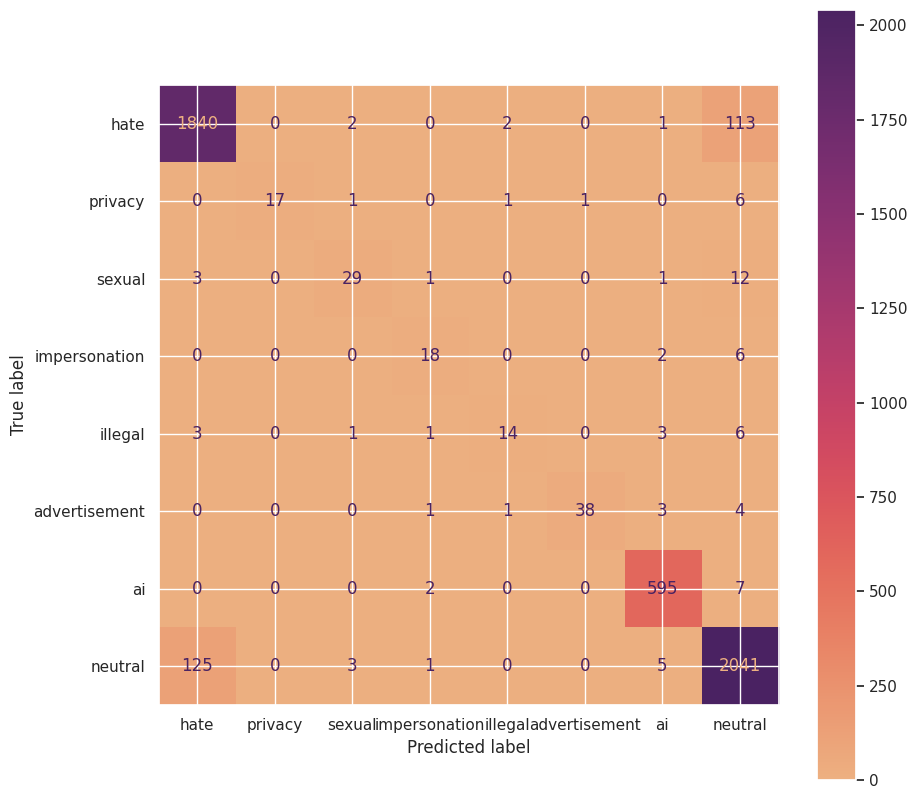

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
ConfusionMatrixDisplay.from_predictions(label_targets, label_preds,
                                        cmap='flare', 
                                        display_labels=[
            'hate',
            'privacy',
            'sexual',
            'impersonation',
            'illegal',
            'advertisement',
            'ai',
            'neutral'
        ])
plt.show()

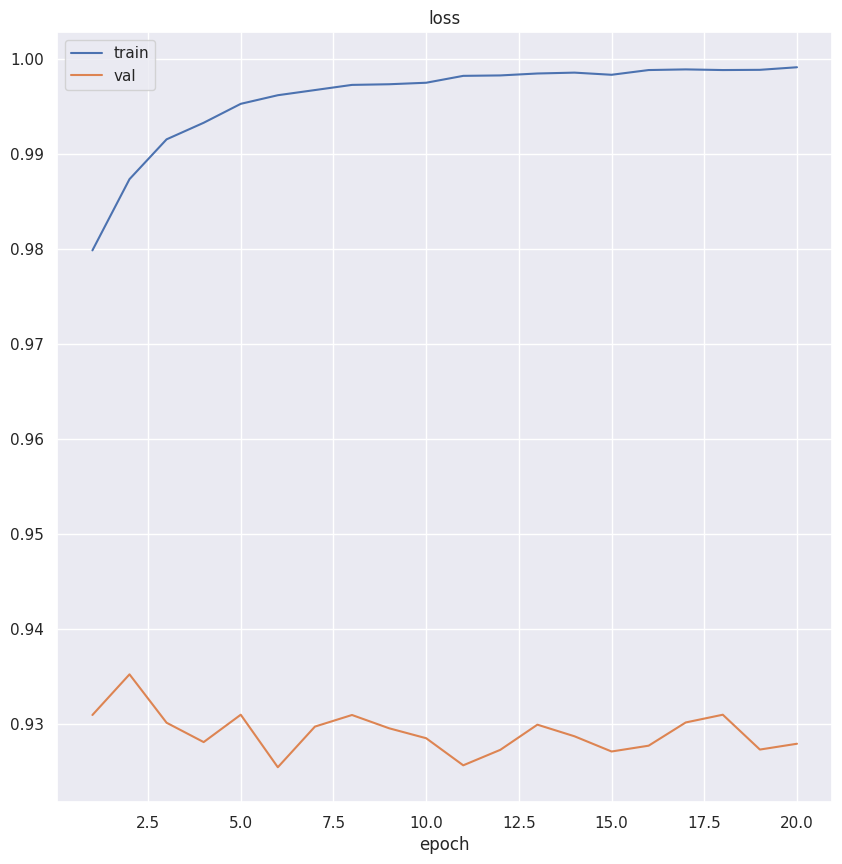

In [ ]:
def plot_training_result(mem, metric):
    xticks = [i+1 for i in range(len(mem[f'train_{metric}']))]
    plt.plot(xticks, mem[f'train_{metric}'])
    plt.plot(xticks, mem[f'val_{metric}'])
    plt.legend(['train', 'val'])
    plt.xlabel('epoch')
    plt.title('loss')
    plt.show()
plot_training_result(mem, 'acc')

# 10-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over the folds
for fold, (train_idx, val_idx) in enumerate(kf.split(df, df["label"])):
    # Get the training and validation data for this fold
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # Save the training and validation data to Excel files
    train_df.to_csv(f'./data/train_fold{fold}.csv', index=False)
    val_df.to_csv(f'./data/val_fold{fold}.csv', index=False)

    # Print the size of the training and validation sets
    print(f'Fold {fold}: Size of training data: {len(train_df)}')
    print(f'Fold {fold}: Size of validation data: {len(val_df)}')

Fold 0: Size of training data: 44188
Fold 0: Size of validation data: 4910
Fold 1: Size of training data: 44188
Fold 1: Size of validation data: 4910
Fold 2: Size of training data: 44188
Fold 2: Size of validation data: 4910
Fold 3: Size of training data: 44188
Fold 3: Size of validation data: 4910
Fold 4: Size of training data: 44188
Fold 4: Size of validation data: 4910
Fold 5: Size of training data: 44188
Fold 5: Size of validation data: 4910
Fold 6: Size of training data: 44188
Fold 6: Size of validation data: 4910
Fold 7: Size of training data: 44188
Fold 7: Size of validation data: 4910
Fold 8: Size of training data: 44189
Fold 8: Size of validation data: 4909
Fold 9: Size of training data: 44189
Fold 9: Size of validation data: 4909


In [ ]:
import glob
train_data_patt = './data/train_fold*.csv'
val_data_patt = './data/val_fold*.csv'

train_data_paths = glob.glob(train_data_patt)
val_data_paths = glob.glob(val_data_patt)

In [ ]:
train_data_paths

['./data/train_fold0.csv',
 './data/train_fold1.csv',
 './data/train_fold2.csv',
 './data/train_fold3.csv',
 './data/train_fold4.csv',
 './data/train_fold5.csv',
 './data/train_fold6.csv',
 './data/train_fold7.csv',
 './data/train_fold8.csv',
 './data/train_fold9.csv']

In [ ]:
model_ckpt = "GroNLP/hateBERT"
batch_size = 32

cur_best_f1 = 0
best_fold = 0
best_mem= {}

for fold in range(10):
    model = SingleClassifier(model_ckpt, nlabels=8).to(device)
    model.unfreeze_encoder()
    n_epoch = 15
    loss_fn = focal_loss() # nn.CrossEntropyLoss()
    ft_criterion = ft_reg_loss(model.encoder)
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    train_data_path = train_data_paths[fold]
    val_data_path = val_data_paths[fold]
    train_ds = DS(train_data_path, sheet_name, model_ckpt)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          drop_last=True, collate_fn=train_ds.collate_fn)
    val_ds = DS(val_data_path, sheet_name, model_ckpt)
    val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

    print(f'Fold {fold+1}:')

    mem = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
    }

    for epoch in tqdm(range(n_epoch), desc='Training'):

        n_batch = len(train_dl)
        train_losses = []
        train_accs = []
        train_f1s = []

        for i, data in enumerate(train_dl):
          
            train_loss, train_metrics = train(data, model, optimizer, loss_fn, loss_fn, ft_criterion)
            pos = epoch + ((i+1)/n_batch)
            train_losses.append(train_loss.cpu().detach())
            train_accs.append(train_metrics['acc'])
            train_f1s.append(train_metrics['f1'])
            log = f"epoch: {pos:.3f}\ttrain loss: {train_loss:.3f}\ttrain_acc: {train_metrics['acc']:.3f}\ttrain_f1: {train_metrics['f1']:.3f}"
            print('\r', log, end='')
        
        mem['train_loss'].append(np.mean(train_losses))
        mem['train_acc'].append(np.mean(train_accs))
        mem['train_f1'].append(np.mean(train_f1s))

        n_batch = len(val_dl)
        val_losses = []
        val_accs = []
        val_f1s = []

        for i, data in enumerate(val_dl):
            val_loss, val_metrics = validate(data, model, loss_fn)
            pos = epoch + ((i+1)/n_batch)
            val_losses.append(val_loss.cpu().detach())
            val_accs.append(val_metrics['acc'])
            val_f1s.append(val_metrics['f1'])
            log = f"epoch: {pos:.3f}\tval loss: {val_loss:.3f}\tval_acc: {val_metrics['acc']:.3f}\tval_f1: {val_metrics['f1']:.3f}"
            print('\r', log, end='')
        
        print('\r', end='')
        mem['val_loss'].append(np.mean(val_losses))
        mem['val_acc'].append(np.mean(val_accs))
        mem['val_f1'].append(np.mean(val_f1s))

        log = f"epoch: {epoch+1}\ntrain loss: {mem['train_loss'][-1]:.3f}\ttrain_acc: {mem['train_acc'][-1]:.3f}\ttrain_f1: {mem['train_f1'][-1]:.3f}"
        log = log + f"\nval loss:   {mem['val_loss'][-1]:.3f}\tval_acc:   {mem['val_acc'][-1]:.3f}\tval_f1:   {mem['val_f1'][-1]:.3f}\n"
        logger.info(log)
        print(log)
        scheduler.step()    

        if mem['val_f1'][-1] > cur_best_f1:
            torch.save(model.state_dict(), f"cv_weights.pth")
            cur_best_f1 = mem['val_f1'][-1]
            best_fold = fold
            best_mem = mem

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 1:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.165	train_acc: 0.884	train_f1: 0.877
val loss:   0.089	val_acc:   0.925	val_f1:   0.931

epoch: 2
train loss: 0.072	train_acc: 0.930	train_f1: 0.928
val loss:   0.080	val_acc:   0.933	val_f1:   0.937

epoch: 3
train loss: 0.046	train_acc: 0.946	train_f1: 0.946
val loss:   0.083	val_acc:   0.927	val_f1:   0.933

epoch: 4
train loss: 0.034	train_acc: 0.957	train_f1: 0.957
val loss:   0.086	val_acc:   0.934	val_f1:   0.939

epoch: 5
train loss: 0.026	train_acc: 0.966	train_f1: 0.965
val loss:   0.093	val_acc:   0.930	val_f1:   0.934

epoch: 6
train loss: 0.019	train_acc: 0.973	train_f1: 0.973
val loss:   0.100	val_acc:   0.923	val_f1:   0.930

epoch: 7
train loss: 0.014	train_acc: 0.981	train_f1: 0.981
val loss:   0.114	val_acc:   0.926	val_f1:   0.932

epoch: 8
train loss: 0.010	train_acc: 0.986	train_f1: 0.986
val loss:   0.123	val_acc:   0.924	val_f1:   0.929

epoch: 9
train loss: 0.007	train_acc: 0.991	train_f1: 0.991
val loss:   0.151	val_acc:   0.925	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 2:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.162	train_acc: 0.884	train_f1: 0.878
val loss:   0.089	val_acc:   0.922	val_f1:   0.927

epoch: 2
train loss: 0.074	train_acc: 0.930	train_f1: 0.928
val loss:   0.079	val_acc:   0.929	val_f1:   0.934

epoch: 3
train loss: 0.047	train_acc: 0.946	train_f1: 0.945
val loss:   0.076	val_acc:   0.934	val_f1:   0.939

epoch: 4
train loss: 0.033	train_acc: 0.958	train_f1: 0.957
val loss:   0.086	val_acc:   0.933	val_f1:   0.939

epoch: 5
train loss: 0.024	train_acc: 0.968	train_f1: 0.967
val loss:   0.090	val_acc:   0.931	val_f1:   0.936

epoch: 6
train loss: 0.018	train_acc: 0.974	train_f1: 0.974
val loss:   0.101	val_acc:   0.928	val_f1:   0.932

epoch: 7
train loss: 0.013	train_acc: 0.981	train_f1: 0.981
val loss:   0.112	val_acc:   0.934	val_f1:   0.938

epoch: 8
train loss: 0.009	train_acc: 0.987	train_f1: 0.987
val loss:   0.131	val_acc:   0.929	val_f1:   0.935

epoch: 9
train loss: 0.007	train_acc: 0.991	train_f1: 0.991
val loss:   0.150	val_acc:   0.933	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 3:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.161	train_acc: 0.887	train_f1: 0.880
val loss:   0.084	val_acc:   0.927	val_f1:   0.933

epoch: 2
train loss: 0.072	train_acc: 0.932	train_f1: 0.931
val loss:   0.076	val_acc:   0.930	val_f1:   0.935

epoch: 3
train loss: 0.047	train_acc: 0.948	train_f1: 0.947
val loss:   0.076	val_acc:   0.934	val_f1:   0.939

epoch: 4
train loss: 0.033	train_acc: 0.957	train_f1: 0.957
val loss:   0.086	val_acc:   0.930	val_f1:   0.933

epoch: 5
train loss: 0.025	train_acc: 0.967	train_f1: 0.967
val loss:   0.092	val_acc:   0.928	val_f1:   0.931

epoch: 6
train loss: 0.019	train_acc: 0.974	train_f1: 0.974
val loss:   0.102	val_acc:   0.926	val_f1:   0.928

epoch: 7
train loss: 0.014	train_acc: 0.981	train_f1: 0.981
val loss:   0.117	val_acc:   0.928	val_f1:   0.931

epoch: 8
train loss: 0.010	train_acc: 0.987	train_f1: 0.987
val loss:   0.122	val_acc:   0.930	val_f1:   0.933

epoch: 9
train loss: 0.007	train_acc: 0.990	train_f1: 0.990
val loss:   0.130	val_acc:   0.924	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 4:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.160	train_acc: 0.886	train_f1: 0.879
val loss:   0.099	val_acc:   0.921	val_f1:   0.923

epoch: 2
train loss: 0.073	train_acc: 0.932	train_f1: 0.931
val loss:   0.093	val_acc:   0.926	val_f1:   0.928

epoch: 3
train loss: 0.046	train_acc: 0.948	train_f1: 0.948
val loss:   0.095	val_acc:   0.928	val_f1:   0.932

epoch: 4
train loss: 0.033	train_acc: 0.959	train_f1: 0.958
val loss:   0.106	val_acc:   0.932	val_f1:   0.935

epoch: 5
train loss: 0.024	train_acc: 0.967	train_f1: 0.967
val loss:   0.110	val_acc:   0.930	val_f1:   0.933

epoch: 6
train loss: 0.019	train_acc: 0.974	train_f1: 0.974
val loss:   0.121	val_acc:   0.927	val_f1:   0.929

epoch: 7
train loss: 0.013	train_acc: 0.981	train_f1: 0.981
val loss:   0.141	val_acc:   0.924	val_f1:   0.929

epoch: 8
train loss: 0.009	train_acc: 0.988	train_f1: 0.988
val loss:   0.157	val_acc:   0.928	val_f1:   0.931

epoch: 9
train loss: 0.007	train_acc: 0.991	train_f1: 0.991
val loss:   0.157	val_acc:   0.922	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 5:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.157	train_acc: 0.888	train_f1: 0.881
val loss:   0.091	val_acc:   0.916	val_f1:   0.921

epoch: 2
train loss: 0.071	train_acc: 0.931	train_f1: 0.929
val loss:   0.086	val_acc:   0.929	val_f1:   0.934

epoch: 3
train loss: 0.046	train_acc: 0.948	train_f1: 0.947
val loss:   0.093	val_acc:   0.923	val_f1:   0.925

epoch: 4
train loss: 0.033	train_acc: 0.958	train_f1: 0.958
val loss:   0.103	val_acc:   0.914	val_f1:   0.921

epoch: 5
train loss: 0.025	train_acc: 0.967	train_f1: 0.967
val loss:   0.103	val_acc:   0.933	val_f1:   0.938

epoch: 6
train loss: 0.019	train_acc: 0.973	train_f1: 0.973
val loss:   0.116	val_acc:   0.926	val_f1:   0.934

epoch: 7
train loss: 0.014	train_acc: 0.981	train_f1: 0.981
val loss:   0.126	val_acc:   0.926	val_f1:   0.930

epoch: 8
train loss: 0.010	train_acc: 0.986	train_f1: 0.986
val loss:   0.143	val_acc:   0.925	val_f1:   0.931

epoch: 9
train loss: 0.008	train_acc: 0.990	train_f1: 0.990
val loss:   0.148	val_acc:   0.930	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 6:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.160	train_acc: 0.885	train_f1: 0.878
val loss:   0.102	val_acc:   0.914	val_f1:   0.917

epoch: 2
train loss: 0.072	train_acc: 0.931	train_f1: 0.930
val loss:   0.086	val_acc:   0.932	val_f1:   0.935

epoch: 3
train loss: 0.047	train_acc: 0.948	train_f1: 0.947
val loss:   0.091	val_acc:   0.930	val_f1:   0.932

epoch: 4
train loss: 0.033	train_acc: 0.960	train_f1: 0.959
val loss:   0.099	val_acc:   0.929	val_f1:   0.932

epoch: 5
train loss: 0.025	train_acc: 0.967	train_f1: 0.966
val loss:   0.115	val_acc:   0.927	val_f1:   0.929

epoch: 6
train loss: 0.019	train_acc: 0.975	train_f1: 0.975
val loss:   0.115	val_acc:   0.930	val_f1:   0.933

epoch: 7
train loss: 0.013	train_acc: 0.981	train_f1: 0.981
val loss:   0.132	val_acc:   0.929	val_f1:   0.932

epoch: 8
train loss: 0.010	train_acc: 0.988	train_f1: 0.988
val loss:   0.143	val_acc:   0.929	val_f1:   0.932

epoch: 9
train loss: 0.007	train_acc: 0.991	train_f1: 0.991
val loss:   0.171	val_acc:   0.925	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 7:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.163	train_acc: 0.883	train_f1: 0.876
val loss:   0.088	val_acc:   0.927	val_f1:   0.935

epoch: 2
train loss: 0.073	train_acc: 0.930	train_f1: 0.928
val loss:   0.080	val_acc:   0.929	val_f1:   0.936

epoch: 3
train loss: 0.049	train_acc: 0.945	train_f1: 0.944
val loss:   0.089	val_acc:   0.930	val_f1:   0.935

epoch: 4
train loss: 0.034	train_acc: 0.956	train_f1: 0.956
val loss:   0.102	val_acc:   0.927	val_f1:   0.933

epoch: 5
train loss: 0.027	train_acc: 0.964	train_f1: 0.964
val loss:   0.096	val_acc:   0.930	val_f1:   0.936

epoch: 6
train loss: 0.020	train_acc: 0.972	train_f1: 0.972
val loss:   0.108	val_acc:   0.933	val_f1:   0.938

epoch: 7
train loss: 0.015	train_acc: 0.979	train_f1: 0.979
val loss:   0.116	val_acc:   0.928	val_f1:   0.933

epoch: 8
train loss: 0.010	train_acc: 0.986	train_f1: 0.986
val loss:   0.134	val_acc:   0.934	val_f1:   0.939

epoch: 9
train loss: 0.008	train_acc: 0.990	train_f1: 0.990
val loss:   0.144	val_acc:   0.926	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 8:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.169	train_acc: 0.881	train_f1: 0.874
val loss:   0.096	val_acc:   0.927	val_f1:   0.932

epoch: 2
train loss: 0.074	train_acc: 0.930	train_f1: 0.928
val loss:   0.086	val_acc:   0.932	val_f1:   0.937

epoch: 3
train loss: 0.047	train_acc: 0.946	train_f1: 0.946
val loss:   0.091	val_acc:   0.932	val_f1:   0.937

epoch: 4
train loss: 0.033	train_acc: 0.958	train_f1: 0.957
val loss:   0.095	val_acc:   0.935	val_f1:   0.940

epoch: 5
train loss: 0.026	train_acc: 0.965	train_f1: 0.965
val loss:   0.106	val_acc:   0.931	val_f1:   0.937

epoch: 6
train loss: 0.019	train_acc: 0.974	train_f1: 0.973
val loss:   0.118	val_acc:   0.933	val_f1:   0.937

epoch: 7
train loss: 0.014	train_acc: 0.980	train_f1: 0.980
val loss:   0.123	val_acc:   0.932	val_f1:   0.936

epoch: 8
train loss: 0.010	train_acc: 0.986	train_f1: 0.986
val loss:   0.136	val_acc:   0.929	val_f1:   0.934

epoch: 9
train loss: 0.007	train_acc: 0.991	train_f1: 0.991
val loss:   0.152	val_acc:   0.929	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 9:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.158	train_acc: 0.887	train_f1: 0.879
val loss:   0.092	val_acc:   0.918	val_f1:   0.921

epoch: 2
train loss: 0.071	train_acc: 0.933	train_f1: 0.931
val loss:   0.082	val_acc:   0.926	val_f1:   0.932

epoch: 3
train loss: 0.046	train_acc: 0.948	train_f1: 0.947
val loss:   0.085	val_acc:   0.924	val_f1:   0.930

epoch: 4
train loss: 0.033	train_acc: 0.958	train_f1: 0.958
val loss:   0.096	val_acc:   0.925	val_f1:   0.929

epoch: 5
train loss: 0.025	train_acc: 0.967	train_f1: 0.966
val loss:   0.099	val_acc:   0.926	val_f1:   0.931

epoch: 6
train loss: 0.019	train_acc: 0.974	train_f1: 0.973
val loss:   0.120	val_acc:   0.924	val_f1:   0.929

epoch: 7
train loss: 0.014	train_acc: 0.980	train_f1: 0.980
val loss:   0.125	val_acc:   0.924	val_f1:   0.929

epoch: 8
train loss: 0.010	train_acc: 0.987	train_f1: 0.987
val loss:   0.133	val_acc:   0.920	val_f1:   0.926

epoch: 9
train loss: 0.007	train_acc: 0.990	train_f1: 0.990
val loss:   0.160	val_acc:   0.927	val_f1:  

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 10:


Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1
train loss: 0.160	train_acc: 0.886	train_f1: 0.879
val loss:   0.093	val_acc:   0.920	val_f1:   0.927

epoch: 2
train loss: 0.073	train_acc: 0.930	train_f1: 0.929
val loss:   0.085	val_acc:   0.928	val_f1:   0.931

epoch: 3
train loss: 0.045	train_acc: 0.948	train_f1: 0.948
val loss:   0.085	val_acc:   0.931	val_f1:   0.935

epoch: 4
train loss: 0.033	train_acc: 0.958	train_f1: 0.957
val loss:   0.088	val_acc:   0.931	val_f1:   0.934

epoch: 5
train loss: 0.026	train_acc: 0.966	train_f1: 0.966
val loss:   0.107	val_acc:   0.928	val_f1:   0.930

epoch: 6
train loss: 0.019	train_acc: 0.974	train_f1: 0.974
val loss:   0.113	val_acc:   0.927	val_f1:   0.929

epoch: 7
train loss: 0.013	train_acc: 0.981	train_f1: 0.981
val loss:   0.116	val_acc:   0.927	val_f1:   0.929

epoch: 8
train loss: 0.010	train_acc: 0.986	train_f1: 0.986
val loss:   0.132	val_acc:   0.927	val_f1:   0.930

epoch: 9
train loss: 0.007	train_acc: 0.991	train_f1: 0.991
val loss:   0.150	val_acc:   0.924	val_f1:  

Cross Entropy

In [ ]:
model_weight = torch.load("cv_weights.pth")
model.load_state_dict(model_weight)

<All keys matched successfully>

In [ ]:
label_preds, label_targets = [], []

val_data_path = val_data_paths[best_fold]
val_ds = DS(val_data_path, sheet_name, model_ckpt)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

with torch.no_grad():
    for i, data in tqdm(enumerate(val_dl), total=len(val_dl)):
        comments, labels = data
        label_outputs = model(comments)

        label_preds.extend(label_outputs.argmax(-1).cpu().numpy())
        label_targets.extend(labels.cpu().numpy())

    print("label")
    print(classification_report(label_targets, label_preds))

  0%|          | 0/154 [00:00<?, ?it/s]

label
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1958
           1       0.66      0.73      0.69        26
           2       0.67      0.57      0.61        46
           3       0.60      0.46      0.52        26
           4       0.50      0.57      0.53        28
           5       0.78      0.83      0.80        47
           6       0.98      0.98      0.98       604
           7       0.94      0.93      0.94      2175

    accuracy                           0.93      4910
   macro avg       0.76      0.75      0.75      4910
weighted avg       0.93      0.93      0.93      4910



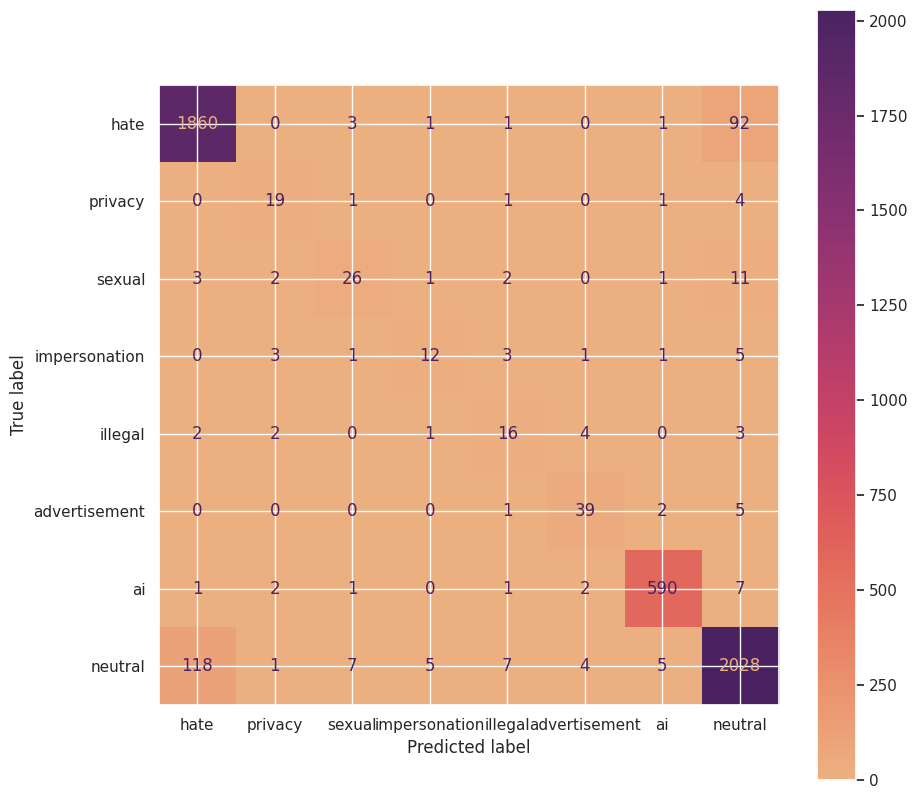

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
ConfusionMatrixDisplay.from_predictions(label_targets, label_preds,
                                        cmap='flare', 
                                        display_labels=[
            'hate',
            'privacy',
            'sexual',
            'impersonation',
            'illegal',
            'advertisement',
            'ai',
            'neutral'
        ])
plt.show()

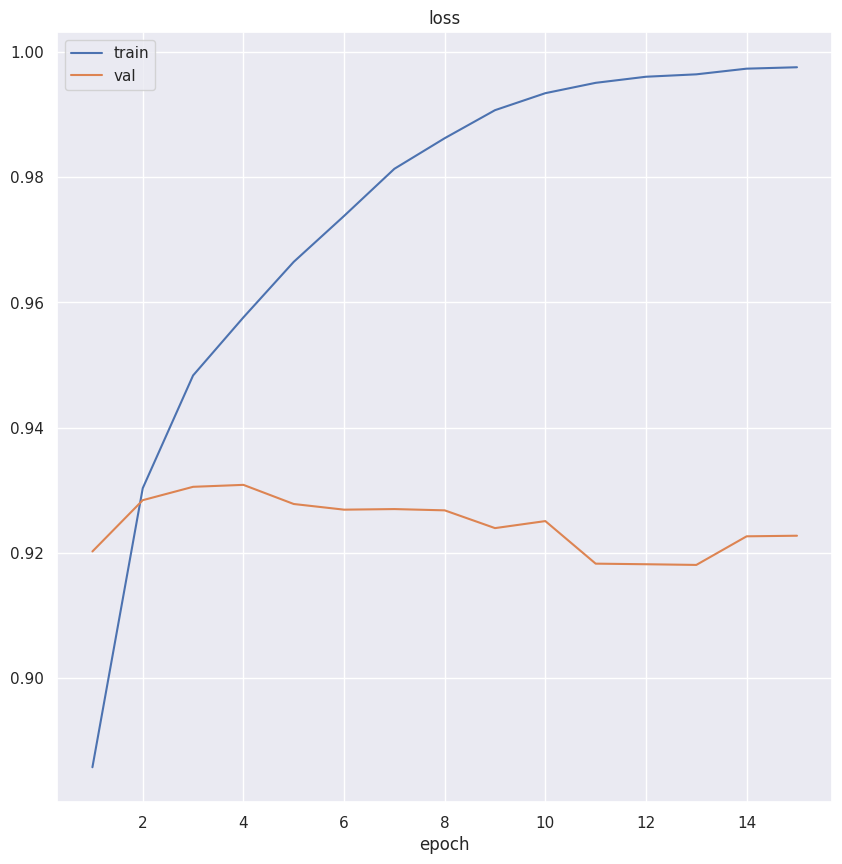

In [ ]:
def plot_training_result(mem, metric):
    xticks = [i+1 for i in range(len(mem[f'train_{metric}']))]
    plt.plot(xticks, mem[f'train_{metric}'])
    plt.plot(xticks, mem[f'val_{metric}'])
    plt.legend(['train', 'val'])
    plt.xlabel('epoch')
    plt.title('loss')
    plt.show()
plot_training_result(mem, 'acc')

# Model Training with ALL data for end product integration

In [ ]:
df.to_csv("./data/full_train.csv")

In [ ]:
model_ckpt = "GroNLP/hateBERT"
batch_size = 32
train_ds = DS("./data/full_train.csv", sheet_name, model_ckpt)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      drop_last=True, collate_fn=train_ds.collate_fn)
val_ds = DS("./data/full_train.csv", sheet_name, model_ckpt)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

In [ ]:
model = SingleClassifier(model_ckpt, nlabels=8).to(device)
model.unfreeze_encoder()
#model.get_summary()

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
n_epoch = 20
loss_fn = focal_loss() # nn.CrossEntropyLoss()
ft_criterion = ft_reg_loss(model.encoder)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [ ]:
mem = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

cur_best_f1 = 0

for epoch in tqdm(range(n_epoch), desc='Training'):

    n_batch = len(train_dl)
    train_losses = []
    train_accs = []
    train_f1s = []

    for i, data in enumerate(train_dl):
        train_loss, train_metrics = train(data, model, optimizer, loss_fn, loss_fn, ft_criterion)
        pos = epoch + ((i+1)/n_batch)
        train_losses.append(train_loss.cpu().detach())
        train_accs.append(train_metrics['acc'])
        train_f1s.append(train_metrics['f1'])
        log = f"epoch: {pos:.3f}\ttrain loss: {train_loss:.3f}\ttrain_acc: {train_metrics['acc']:.3f}\ttrain_f1: {train_metrics['f1']:.3f}"
        print('\r', log, end='')
    
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_acc'].append(np.mean(train_accs))
    mem['train_f1'].append(np.mean(train_f1s))

    n_batch = len(val_dl)
    val_losses = []
    val_accs = []
    val_f1s = []

    for i, data in enumerate(val_dl):
        val_loss, val_metrics = validate(data, model, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        val_losses.append(val_loss.cpu().detach())
        val_accs.append(val_metrics['acc'])
        val_f1s.append(val_metrics['f1'])
        log = f"epoch: {pos:.3f}\tval loss: {val_loss:.3f}\tval_acc: {val_metrics['acc']:.3f}\tval_f1: {val_metrics['f1']:.3f}"
        print('\r', log, end='')
    
    print('\r', end='')
    mem['val_loss'].append(np.mean(val_losses))
    mem['val_acc'].append(np.mean(val_accs))
    mem['val_f1'].append(np.mean(val_f1s))

    log = f"epoch: {epoch+1}\ntrain loss: {mem['train_loss'][-1]:.3f}\ttrain_acc: {mem['train_acc'][-1]:.3f}\ttrain_f1: {mem['train_f1'][-1]:.3f}"
    log = log + f"\nval loss:   {mem['val_loss'][-1]:.3f}\tval_acc:   {mem['val_acc'][-1]:.3f}\tval_f1:   {mem['val_f1'][-1]:.3f}\n"
    logger.info(log)
    print(log)
    scheduler.step()    

    if mem['val_f1'][-1] > cur_best_f1:
        torch.save(model.state_dict(), f"final_model_weights_full.pth")
        cur_best_f1 = mem['val_f1'][-1]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1
train loss: 0.158	train_acc: 0.887	train_f1: 0.880
val loss:   0.059	val_acc:   0.943	val_f1:   0.946

epoch: 2
train loss: 0.072	train_acc: 0.930	train_f1: 0.929
val loss:   0.035	val_acc:   0.959	val_f1:   0.960

epoch: 3
train loss: 0.046	train_acc: 0.946	train_f1: 0.946
val loss:   0.024	val_acc:   0.969	val_f1:   0.968

epoch: 4
train loss: 0.033	train_acc: 0.958	train_f1: 0.958
val loss:   0.017	val_acc:   0.976	val_f1:   0.976

epoch: 5
train loss: 0.026	train_acc: 0.966	train_f1: 0.966
val loss:   0.011	val_acc:   0.985	val_f1:   0.985

epoch: 6
train loss: 0.019	train_acc: 0.974	train_f1: 0.974
val loss:   0.009	val_acc:   0.992	val_f1:   0.992

epoch: 7
train loss: 0.014	train_acc: 0.981	train_f1: 0.981
val loss:   0.005	val_acc:   0.996	val_f1:   0.996

epoch: 8
train loss: 0.010	train_acc: 0.987	train_f1: 0.987
val loss:   0.003	val_acc:   0.997	val_f1:   0.998

epoch: 9
train loss: 0.008	train_acc: 0.991	train_f1: 0.991
val loss:   0.002	val_acc:   0.998	val_f1:  